In [1]:
import matplotlib
import matplotlib.pyplot as plt
import noise_correlations
import numpy as np
import os
import pickle

from importlib import reload
from neuropacks import PVC11
from noise_correlations import (analysis,
                                discriminability,
                                null_models,
                                utils,
                                plot)

from pratplot import colorbar as pcb
from pratplot import ellipse

%matplotlib inline

In [2]:
# Load PVC11 dataset
base_path = '/Volumes/pss/data/pvc11/data/spikes_gratings'
data_path = os.path.join(base_path, 'data_monkey1_gratings.mat')
pack = PVC11(data_path)

In [3]:
# Get response matrix for PVC11 dataset, and stimuli
X = pack.get_response_matrix(transform=None)
stimuli = pack.get_design_matrix(form='angle')
# Delete neurons that don't response at all to a stimulus
X = np.delete(X, utils.get_nonresponsive_for_stim(X, stimuli), axis=1)
# Get units that are overall "responsive"
responsive_units = utils.get_responsive_units(
    X, stimuli, aggregator=np.mean,
    peak_response=10.)
X = X[:, responsive_units]

In [4]:
# Random state
rng = np.random.RandomState(2332)

In [5]:
dims = np.array([2, 5, 10, 20])
n_dims = dims.size
n_dimlets = 20
n_repeats = 1000
n_pairings = n_dimlets * pack.n_stimuli
v_s_lfis = np.zeros((n_dims, n_pairings, n_repeats))
v_s_sdkls = np.zeros_like(v_s_lfis)
v_r_lfis = np.zeros_like(v_s_lfis)
v_r_sdkls = np.zeros_like(v_s_lfis)
v_lfis = np.zeros((n_dims, n_pairings))
v_sdkls = np.zeros_like(v_lfis)
units = {idx: np.zeros((n_pairings, dim)) for idx, dim in enumerate(dims)}
stims = np.zeros((n_dims, n_pairings, 2))

In [6]:
# Calculate null measures across dims
for idx, dim in enumerate(dims):
    print(idx)
    v_s_lfis[idx], v_s_sdkls[idx], v_r_lfis[idx], v_r_sdkls[idx], \
    v_lfis[idx], v_sdkls[idx], units[idx], stims[idx] = \
        analysis.calculate_null_measures(
            X, stimuli,
            n_dim=dim,
            n_dimlets=n_dimlets,
            rng=rng,
            n_repeats=n_repeats,
            circular_stim=True)

0
1
2
3


In [9]:
# Calculate percentiles
p_r_lfi = 100 * np.mean(v_lfis[..., np.newaxis] > v_r_lfis, axis=2)
p_r_sdkl = 100 * np.mean(v_sdkls[..., np.newaxis] > v_r_sdkls, axis=2)

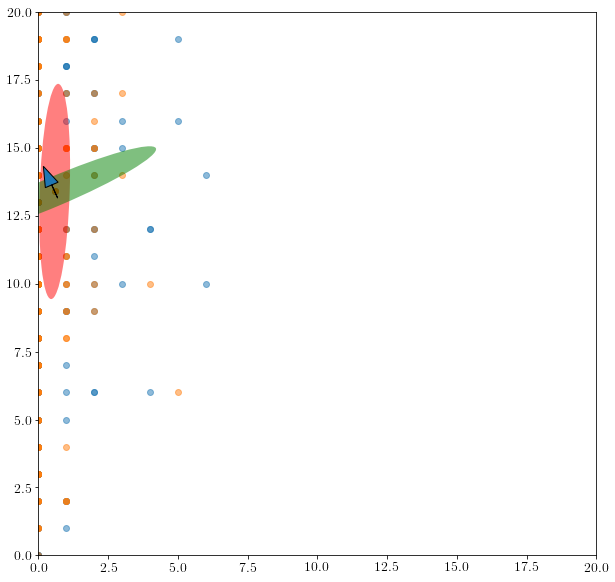

In [176]:
# second plot
rot_idx = 4
stim0_idx = np.argwhere(stimuli == stims[0, rot_idx][0]).ravel()
stim1_idx = np.argwhere(stimuli == stims[0, rot_idx][1]).ravel()
X0 = X[stim0_idx][:, units[0][rot_idx]]
X1 = X[stim1_idx][:, units[0][rot_idx]]

mu0, cov0 = utils.mean_cov(X0)
mu1, cov1 = utils.mean_cov(X1)
fpr = mu1 - mu0
mu_mean = (mu0 + mu1) / 2
cov_avg = (cov0 + cov1) / 2
_, vs = np.linalg.eigh(cov_avg)
v_small = vs[:, 0]
fpr_unit = fpr / np.linalg.norm(fpr)

R = utils.get_rotation_for_vectors(v_small, fpr_unit)
best_cov = R @ cov_avg @ R.T

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#plot.plot_ellipses(mu0, cov0, mu1, cov1, faxes=(fig, ax))
plot_cov_ellipse(cov_avg, alpha=0.5, mu=mu_mean, fax=(fig, ax), fc='red')
plot_cov_ellipse(best_cov, alpha=0.5, mu=mu_mean, fax=(fig, ax), fc='green')

ax.set_xlim([0, 20])
ax.set_ylim([0, 20])
ax.scatter(X0[:, 0], X0[:, 1], color=u'#1f77b4', alpha=0.5)
ax.scatter(X1[:, 0], X1[:, 1], color=u'#ff7f0e', alpha=0.5)
ax.tick_params(labelsize=14)
ax.arrow(mu0[0], mu0[1], mu1[0] - mu0[0], mu1[1] - mu0[1], head_width=0.5, shape='full')

plt.show()

In [21]:
avg_corr = np.zeros((n_dims - 1, n_pairings))
avg_corr_best = np.zeros((n_dims - 1, n_pairings))

for idx, dim_idx in enumerate([1, 2, 3]):
    for pairing in range(n_pairings):
        stim0_idx = np.argwhere(stimuli == stims[dim_idx, pairing][0]).ravel()
        stim1_idx = np.argwhere(stimuli == stims[dim_idx, pairing][1]).ravel()
        X0 = X[stim0_idx][:, units[dim_idx][pairing]]
        X1 = X[stim1_idx][:, units[dim_idx][pairing]]

        mu0, cov0 = utils.mean_cov(X0)
        mu1, cov1 = utils.mean_cov(X1)
        fpr = mu1 - mu0
        avg_cov = (cov0 + cov1) / 2
        _, vs = np.linalg.eigh(avg_cov)
        v_small = vs[:, 0]
        fpr_unit = fpr / np.linalg.norm(fpr)

        R = utils.get_rotation_for_vectors(v_small, fpr_unit)
        best_cov = R @ avg_cov @ R.T


        avg_corr[idx, pairing] = np.mean(
            [np.corrcoef(np.diag(avg_cov), mu0)[0, 1],
             np.corrcoef(np.diag(avg_cov), mu1)[0, 1]]
        )
        avg_corr_best[idx, pairing] = np.mean(
            [np.corrcoef(np.diag(best_cov), mu0)[0, 1],
             np.corrcoef(np.diag(best_cov), mu1)[0, 1]]
        )
        

In [15]:
min_best = np.zeros((n_dims, n_pairings))

for dim_idx in range(n_dims):
    for pairing in range(n_pairings):
        # Get subset of design matrices
        stim0_idx = np.argwhere(stimuli == stims[dim_idx, pairing][0]).ravel()
        stim1_idx = np.argwhere(stimuli == stims[dim_idx, pairing][1]).ravel()
        X0 = X[stim0_idx][:, units[dim_idx][pairing]]
        X1 = X[stim1_idx][:, units[dim_idx][pairing]]
        # Calculate means and covariances
        mu0, cov0 = utils.mean_cov(X0)
        mu1, cov1 = utils.mean_cov(X1)
        # Derivative of tuning direction
        fpr = mu1 - mu0
        fpr_unit = fpr / np.linalg.norm(fpr)
        # Get observed and best covariance matrices
        avg_cov = (cov0 + cov1) / 2
        v_small = np.linalg.eigh(avg_cov)[1][:, 0]
        R = utils.get_rotation_for_vectors(v_small, fpr_unit)
        best_cov = R @ avg_cov @ R.T
        
        # Get principal eigenvectors of best covariance matrix
        u_big_best = np.sqrt(np.linalg.eigh(best_cov)[0][-1])
        v_big_best = np.linalg.eigh(best_cov)[1][:, -1]
        min_best[dim_idx, pairing] = np.min((mu0 - u_big_best * v_big_best,
                                             mu0 + u_big_best * v_big_best,
                                             mu1 - u_big_best * v_big_best,
                                             mu1 + u_big_best * v_big_best))


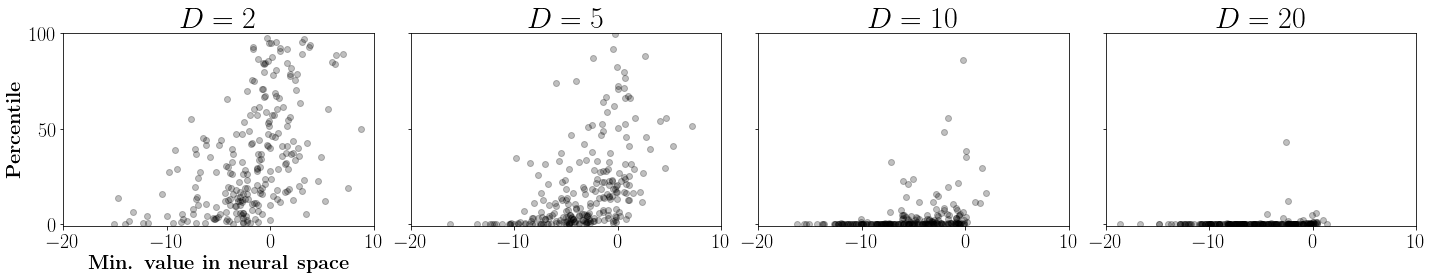

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

for idx, ax in enumerate(axes):
    ax.scatter(min_best[idx], p_r_lfi[idx],
               color='k',
               alpha=0.25)
    ax.set_ylim([-1, 100])
    ax.set_xlim([-20, 10])
    ax.set_title(f'$D={dims[idx]}$')

axes[0].set_xlabel(r'\textbf{Min. value in neural space}', fontsize=20)
axes[0].set_ylabel(r'\textbf{Percentile}', fontsize=20)
    
plt.tight_layout()